In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.linalg import block_diag

from timeit import default_timer
from Solver import *
from functools import partial

import torch

import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import PlotDefault
import NeuralNet
import KalmanInversion




In [2]:
beta_rek_strs = [("1", "0p3"), ("2", "0p3"), ("3", "0p3"), ("1", "0p6"), ("2", "0p6"), ("3", "0p6")]
beta_reks = [ (str_to_num(beta_rek_strs[i][0]), str_to_num(beta_rek_strs[i][1])) for i in range(len(beta_rek_strs)) ]
phy_params, q_mean, psi_mean, dpv_mean,  mu_mean, mu_mean_clip,  closure_mean, xx, force = load_data(beta_rek_strs = beta_rek_strs, beta_reks = beta_reks)


In [3]:
# Visualize data

Text(0.5, 0.98, 'bottom layer')

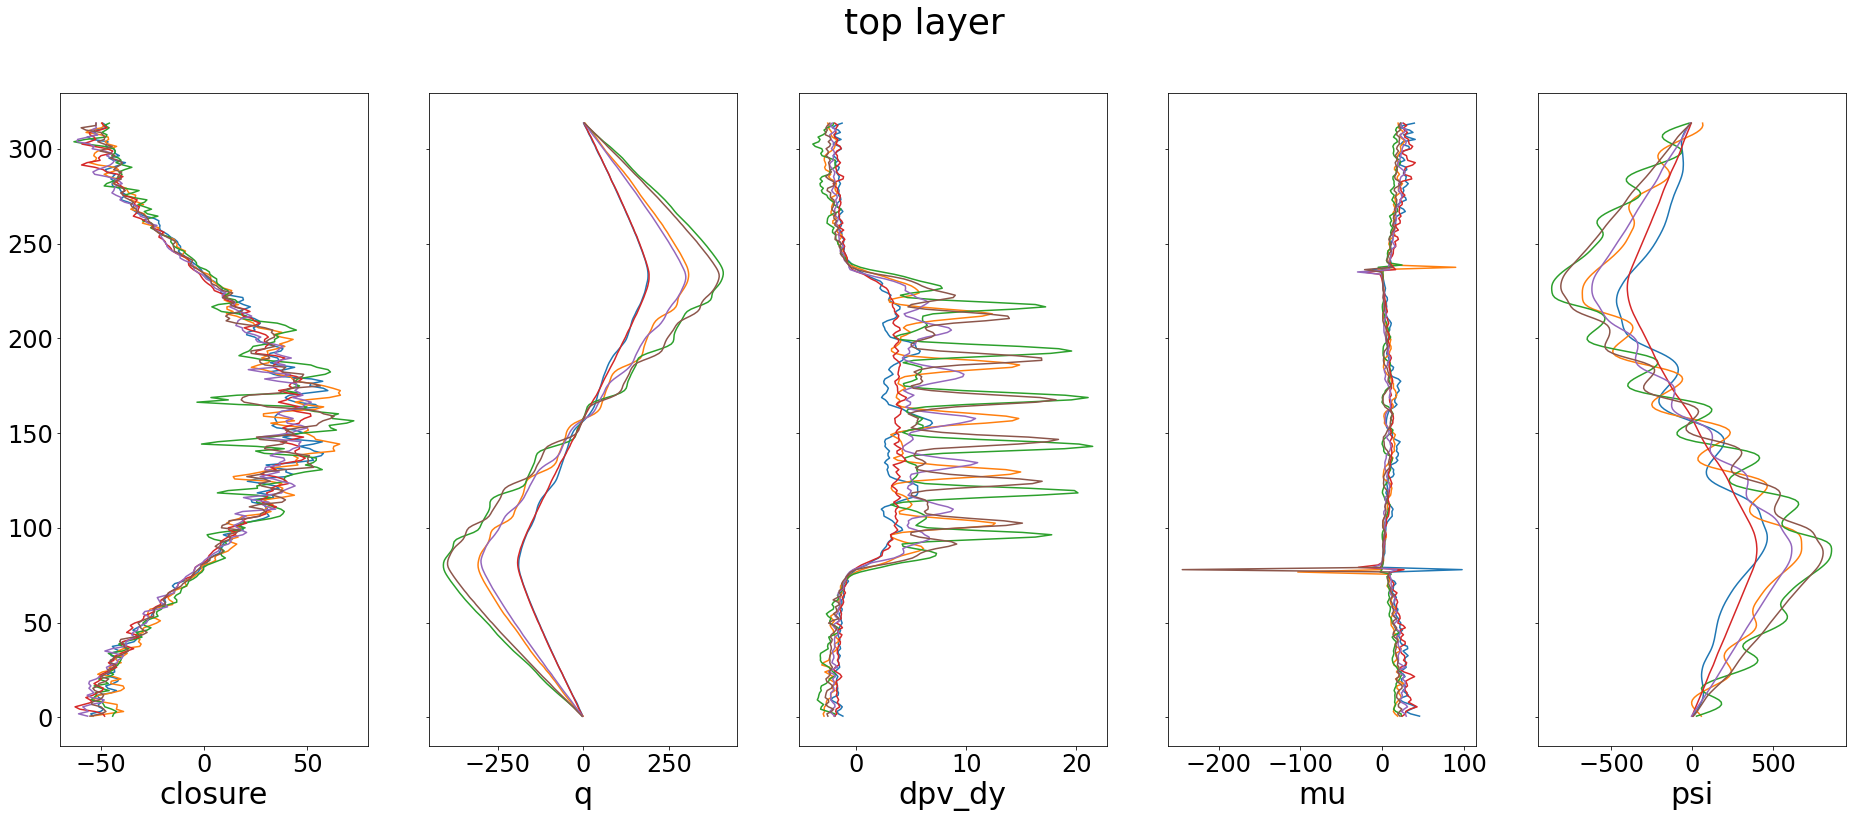

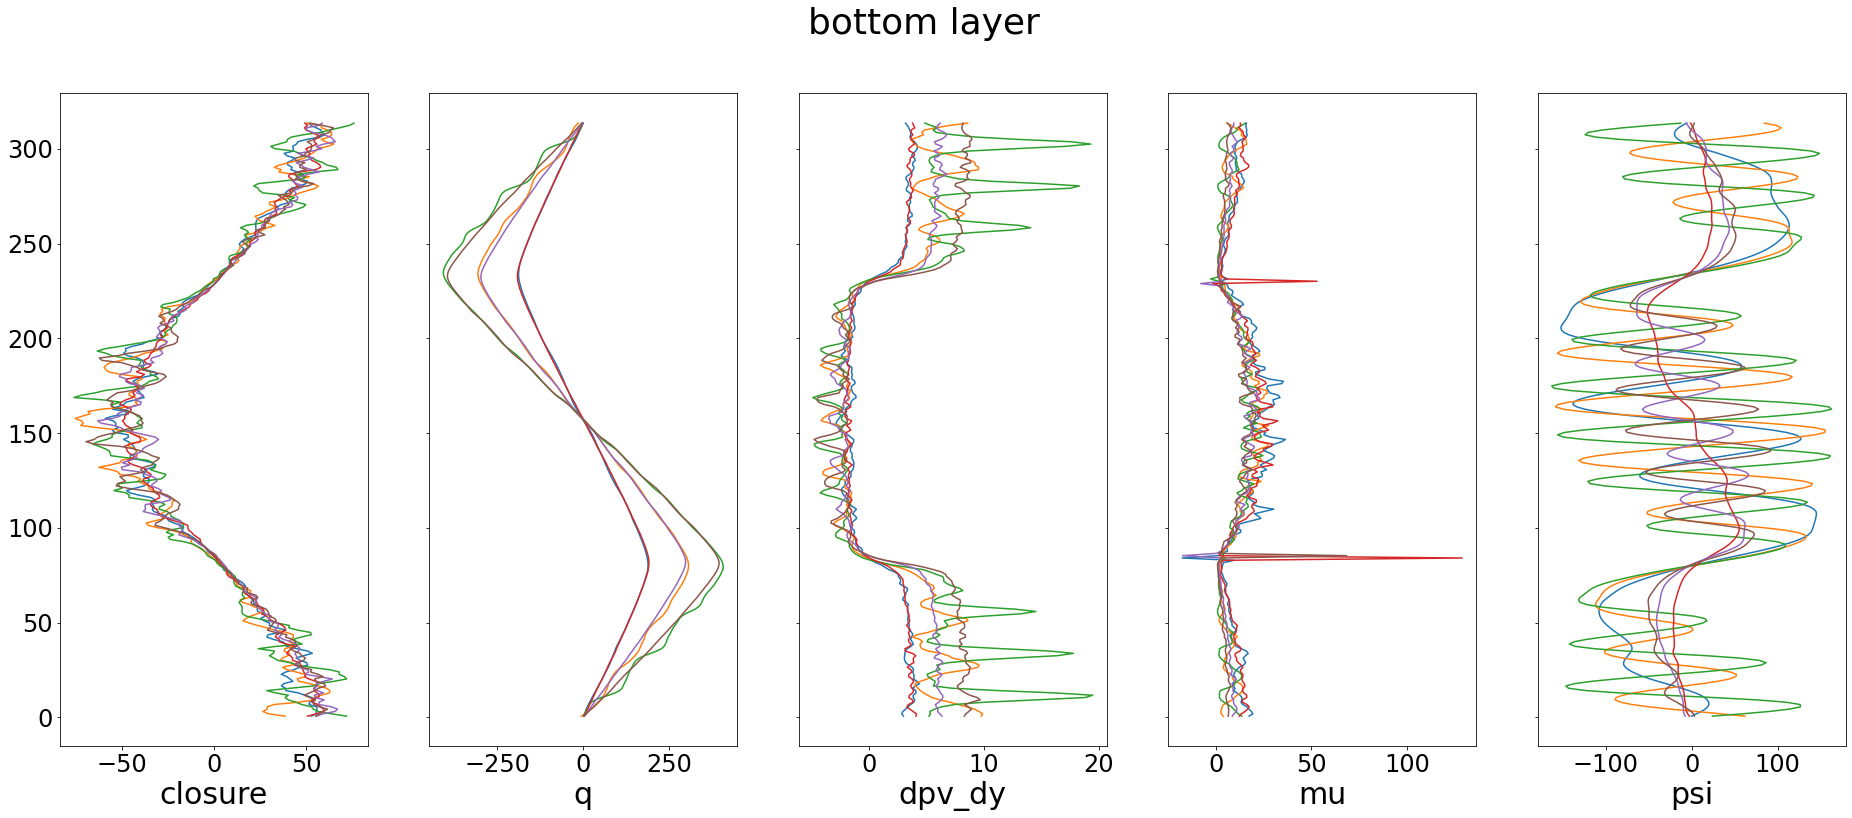

In [4]:
L = 50*2*np.pi
Nx = 256
xx, dx = np.linspace(L/(2*Nx), L - L/(2*Nx), Nx), L/Nx
N_data = len(beta_reks)
Q = 1.0
force = np.zeros((2, Nx))
force[0, :] = -Q * np.sin(2*np.pi*xx/L)
force[1, :] =  Q * np.sin(2*np.pi*xx/L)   





layer = 0
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], xx)
    ax[1].plot(q_mean[i,layer, :], xx)
    ax[2].plot(dpv_mean[i,layer, :], xx)
    ax[3].plot(mu_mean[i,layer, :], xx)
    ax[4].plot(psi_mean[i,layer, :], xx)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("top layer")

layer = 1
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], xx)
    ax[1].plot(q_mean[i,layer, :], xx)
    ax[2].plot(dpv_mean[i,layer, :], xx)
    ax[3].plot(mu_mean[i,layer, :], xx)
    ax[4].plot(psi_mean[i,layer, :], xx)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("bottom layer")

In [5]:
# Training Loss : || d(D dq/dx)/dx + f(x)|| on the quadratic function

In [6]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    dx = xx[1] - xx[0]
    ind, outd, width = s_param.ind, s_param.outd, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, _, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, 2, Nx))
    
    
    net =  NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer,  params)
    nn_model = partial(NeuralNet.nn_viscosity, net=net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    psi = np.zeros_like(q)
    for i in range(N_data):
        beta1 = beta2 = beta = s_param.phy_params[i].beta
        F1, F2 = s_param.phy_params[i].F1, s_param.phy_params[i].F2
        psi[i, :, :] = psi_fft_sol(q[i, :, :], F1, F2, dx)
        dd_psi2 = gradient_fft(psi[i, 1, :], dx, 2)
        nummodel_fft(nn_model, beta1, beta2,  q[i, :, :], psi[i, :, :], xx, res[i, :, :])
        res[i, 1, :] -= s_param.phy_params[i].rek*dd_psi2
    return np.hstack((-np.reshape(res, -1), params))


In [7]:
class QGParam:
    def __init__(self, phy_params, xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.ind  = ind
        self.outd = outd
        self.width = width
        self.activation = activation
        self.initializer = initializer
        self.outputlayer = outputlayer
        
        self.phy_params = phy_params
        
        
        N_theta = ind*width + (layers - 2)*width**2 + width*outd + (layers - 1)*width + outd
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta 

# Start UKI

In [8]:
y = np.tile(force, (len(beta_reks),1,1))
Sigma_eta = np.fabs(y)
y = y.flatten()
for i in range(N_data):
    Sigma_eta[i, :, :] = np.mean(Sigma_eta[i, :, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.01)**2, -1))


N_y = len(y)
s_param = QGParam(phy_params, xx, q_mean, N_y,  ind, outd, layers, width, activation, initializer, outputlayer)


N_theta = s_param.N_theta


# theta0_mean_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()
theta0_mean_init = torch.load("direct.nn").get_params()
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 100.0**2)  
theta0_cov_init = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov_init, 0.1**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)


alpha_reg = 1.0
update_freq = 1
N_iter = 100
gamma = 1.0


save_folder = "indirect_NN_res"
uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
    theta0_mean, theta0_mean_init, 
    theta0_cov,  theta0_cov_init, 
    y_aug, Sigma_eta_aug,
    alpha_reg,
    gamma,
    update_freq, 
    N_iter,
    save_folder = save_folder)

ukiobj.gamma :  1.0
optimization error at iter  0  =  566169961.0724679
data-misfit :  566169959.6679555 reg :  1.404512394136425
Frobenius norm of the covariance at iter  0  =  0.0640312423743285
ukiobj.gamma :  0.5
optimization error at iter  1  =  677200335.5114956
data-misfit :  677200334.3296795 reg :  1.18181610540249
Frobenius norm of the covariance at iter  1  =  0.02805454604475037
ukiobj.gamma :  0.5
optimization error at iter  2  =  490380342.8135728
data-misfit :  490380341.5702598 reg :  1.243313046524332
Frobenius norm of the covariance at iter  2  =  0.048829156783368965
ukiobj.gamma :  0.5
optimization error at iter  3  =  72521292.92345354
data-misfit :  72521291.7407254 reg :  1.182728134299194
Frobenius norm of the covariance at iter  3  =  0.06086987572737644
ukiobj.gamma :  0.5
optimization error at iter  4  =  39547704.221677914
data-misfit :  39547703.168405876 reg :  1.0532720430791425
Frobenius norm of the covariance at iter  4  =  0.0831357767219168
ukiobj.gam